# Goals for today's section
- Go over general problem for w5 homework—the underlying models of data we are considering, and the big picture behind the calculation of evidences for the models.
- Python tricks: how to load and organize your data efficiently. Logical indexing.
- Optional: inference on the parameters from Ex 28.2 Mckay.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## What's the general problem?

For ten different loci, we want to know if the genotype at that locus is linked to the phenotype.

The phenotype for fly $k$ is $f_k$, a song frequency measured in Hz.

At a particular locus, we also have the genotype of the $k$th fly, $g_k$.

Our null model is that the genotype does not explain the phenotype:

$$f_k = c + \epsilon, ~~\epsilon \sim N(0, \sigma^2)$$

Here, $c$ is some constant song frequency, and $\varepsilon$ is a Gaussian noise variable with standard deviation $\sigma$.

Our QTL model:

$$f_k = a + b g_k + \epsilon, ~~\epsilon \sim N(0, \sigma^2)$$

What does this mean?

- if fly $k$ has $g_k = 0$, then its phenotype has mean frequency $a$ with Gaussian noise with variance $\sigma^2$ (a $N(a, \sigma^2)$ process),
- whereas if $g_k = 1$, then it's $N(a+b, \sigma^2)$

Let's visualize this for different $a, b, c$:


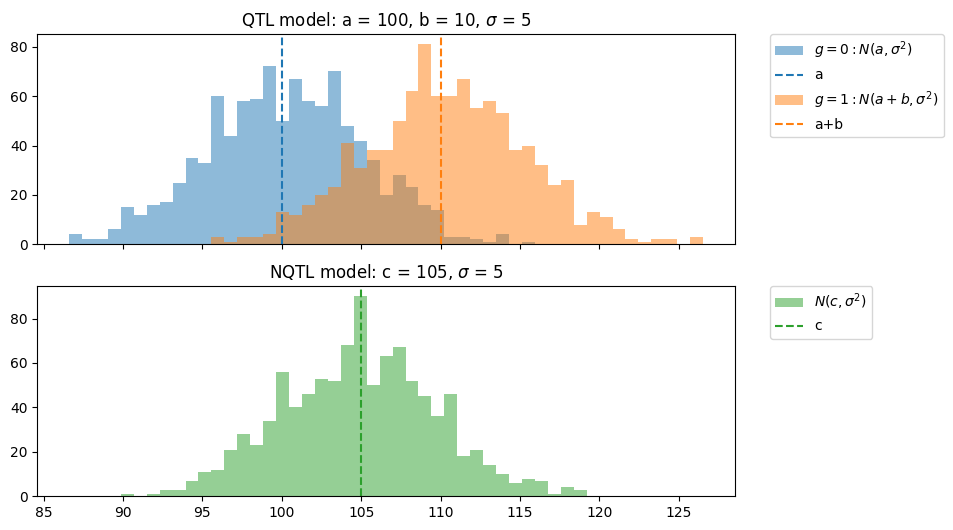

In [ ]:
a = 100
b = 10
#c = 100
c = (a + a + b) / 2
sigma = 5

data_QTL_0 = np.random.normal(loc=a, scale=sigma, size=1000)
data_QTL_1 = np.random.normal(loc=a+b, scale=sigma, size=1000)
data_NQTL = np.random.normal(loc=c, scale=sigma, size=1000)
all_data = [data_QTL_0, data_QTL_1, data_NQTL]
bs = np.linspace(min(np.concatenate(all_data)), max(np.concatenate(all_data)), 50)

fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

# plot QTL case
ax[0].set_title('QTL model: a = {:.0f}, b = {:.0f}, $\sigma$ = {:.0f}'.format(a, b, sigma))
ax[0].hist(data_QTL_0, bins=bs,
         alpha=0.5, label='$g=0: N(a, \sigma^2)$')
ax[0].axvline(a, ls='--', c='C0', label='a')
ax[0].hist(data_QTL_1, bins=bs,
         alpha=0.5, label='$g=1: N(a+b, \sigma^2)$')
ax[0].axvline(a+b, ls='--', c='C1', label='a+b')
ax[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

# plot NQTL case
ax[1].set_title('NQTL model: c = {:.0f}, $\sigma$ = {:.0f}'.format(c, sigma))
ax[1].hist(data_NQTL, bins=bs,
           alpha=0.5, color='C2', label='$N(c, \sigma^2)$')
ax[1].axvline(c, ls='--', c='C2', label='c')
ax[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

plt.show()

Given our data, we want to compare two hypotheses, so let's compute our old friend:

$$\begin{aligned}
\frac{P(D \mid QTL)}{P(D \mid NQTL)}
\end{aligned}$$

Let's go through $P(D \mid NQTL)$.

In the NQTL model, what we assume is that phenotypes are governed by

$$f_k = c + \epsilon, ~~\epsilon \sim N(0, \sigma^2)$$

So, a frequency $f_k$ is assumed to come from a $N(c, \sigma^2)$ distribution.

The pdf of a Gaussian $N(\alpha, \beta)$ is:

$$f(x; \alpha, \beta) = \frac{1}{\sqrt{2\pi}\beta}e^{-\frac{(x-\alpha)^2}{2\beta^2}}$$


That's exactly what we use to write the likelihood of a single datapoint:

$$P(f_k \mid c, \sigma, NQTL) = \frac{1}{\sqrt{2\pi}\sigma}e^{\frac{-(f_k - c)^2}{2\sigma^2}}$$

And for the full data, with $N$ flies:
$$\begin{aligned}
P(D \mid c, \sigma, NQTL) &= \prod_{k=1}^N P(f_k \mid c, \sigma, NQTL) \\
&= \prod_{k=1}^N \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(f_k - c)^2}{2\sigma^2}} \\
&= \frac{1}{(\sqrt{2\pi}\sigma)^N}\prod_{k=1}^N e^{-\frac{(f_k - c)^2}{2\sigma^2}} \\
&= \frac{1}{(\sqrt{2\pi}\sigma)^N} e^{\frac{-\sum_k (f_k - c)^2}{2\sigma^2}} \\
\end{aligned}$$

The $f_k$'s are fixed and given to us. We can compute the term above if we set a particular $c$ and $\sigma$. But, what $c$ should we use? We will marginalize over different $c$. For our homework, it is OK to assume a single $\sigma$ (though in principle, you could leave this as a parameter and marginalize over different $\sigma$'s too).

$$P(D \mid NQTL) = \int_{-\infty}^\infty dc~ P(D \mid c, \sigma, NQTL)P(c \mid NQTL)$$

Similar to previous homeworks, we will consider uniform priors on parameters like $c$ and call $\sigma_c = c_+ -c_-$, where $c_+$ and $c_-$ are endpoints for $c$ that are arbitrary but don't cut off meaningful values.

$$P(D \mid NQTL) = \frac{1}{\sigma_c}\int_{-\infty}^\infty dc~ P(D \mid c, \sigma, NQTL)$$


We need to compute the above integral in order to get the evidence for the NQTL model. What follows in the lecture notes is a simplification of that integral by doing a Taylor expansion around the peak, very similar to how we did the Laplace approximation of using Taylor expansions around a peak of a posterior to find an approximating Gaussian.

Here, we consider the log likelihood:

$$\begin{aligned}
L(c) &= \log P(D \mid c, \sigma, NQTL) \\
&\approx L(c^*) + \frac{1}{2} \frac{\partial^2 L}{\partial c^2} (c - c^*)^2
\end{aligned}$$

We are expanding around an optimal $c^*$, for which the first partial derivative of $L$ in $c$ is zero. Hence, there are no first partial derivatives in the above Taylor expansion. We got this $c^*$ by the following:

$$\frac{\partial L}{\partial c} = \frac{1}{\sigma^2} \sum_k (f_k - c) = 0 \implies c^* = \frac{1}{N} \sum_k f_k = \bar{f}$$


There is another key result from lecture notes, $\frac{\partial^2 L}{\partial c^2} = -\frac{N}{\sigma^2}$, which we will now plug in to the above expression:

$$\begin{aligned}
L(c) &= \log P(D \mid c, \sigma, NQTL) \\
&\approx L(c^*) + \frac{1}{2} \frac{\partial^2 L}{\partial c^2} (c - c^*)^2\\
&\approx L(c^*) - \frac{N}{2\sigma^2} (c - c^*)^2
\end{aligned}$$

Going back to non-logs:

$$\begin{aligned}
P(D \mid c, \sigma, NQTL) &= \exp\big(\log P(D \mid c, \sigma, NQTL)\big)\\
&\approx \exp\big( L(c^*) - \frac{N}{2\sigma^2} (c - c^*)^2 \big)\\
&\approx e^{L(c^*)}e^{-\frac{N}{2\sigma^2} (c - c^*)^2}\\
&\approx P(D \mid c^*, \sigma, NQTL)e^{-\frac{N}{2\sigma^2} (c - c^*)^2}\\
\end{aligned}$$

Plug this into our integral:

$$\begin{aligned}
P(D \mid NQTL) &= \frac{1}{\sigma_c}\int_{-\infty}^\infty dc~ P(D \mid c, \sigma, NQTL) \\
&\approx \frac{1}{\sigma_c}\int_{-\infty}^\infty dc~ P(D \mid c^*, \sigma, NQTL)e^{-\frac{N}{2\sigma^2} (c - c^*)^2}\\
&\approx \frac{1}{\sigma_c} P(D \mid c^*, \sigma, NQTL) \int_{-\infty}^\infty dc~ e^{-\frac{N}{2\sigma^2} (c - c^*)^2}\\
\end{aligned}$$

That integral is simple to integrate (it is a form of a Gaussian integral), so we arrive at a simple expression:

$$P(D\mid NQTL) \approx  P(D\mid c^\ast, \sigma, NQTL) \times \sqrt{\frac{2\pi\sigma^2}{N}}\frac{1}{\sigma_c}$$

Here, $ P(D \mid c^*, \sigma, NQTL)$ is simply the likelihood of the data, given a particular $c=c^* = \frac{1}{N} \sum_k f_k$ (which makes sense, right? In the null model, we assume that genotype has no effect on phenotype, and that each observed phenotype is generated by a gaussian with mean frequency $c$... so if we wanted to estimate $c$, the best we can do is take the mean of the frequencies $f$).

Let's sum up. So what did we do here? We
- assumed that we had a known $\sigma$ (something you can set by looking at the data -- what would be a reasonable choice? You can set this as a variable in your code and see how your results change for different $\sigma$'s if you're interested),
- used a Taylor expansion around the optimal $c$ to approximate $P(D \mid c, \sigma, NQTL)$
- doing that approximation gave us a new integral with an easy analytical answer, giving us a one-line calculation for the integral we wanted to compute in the first place (we don't need to do integration ourselves! just need to evaluate the above expression)

For the QTL model, the lecture notes go through a similar process. But there, we have two parameters, $a$ and $b$, and we incorporate genotype information, $g$.

We will do the same tricks though!

$$\begin{aligned}
P(D\mid QTL) &= \int_{-\infty}^{\infty} da \int_{-\infty}^{\infty} db ~P(D\mid a, b, \sigma, QTL) P(a,b\mid QTL) \\
&= \frac{1}{\sigma_a\sigma_b}\int_{-\infty}^{\infty} da \int_{-\infty}^{\infty} db ~P(D\mid a, b, \sigma, QTL) \\
&\approx \frac{1}{\sigma_a\sigma_b} P(D\mid a^*, b^*, \sigma, QTL)\int_{-\infty}^{\infty} da \int_{-\infty}^{\infty} db ~e^{-\frac{1}{2}(a-a^*, b-b^*)Q{a-a^\ast\choose b-b^\ast}} \\
&\approx \frac{1}{\sigma_a\sigma_b} P(D\mid a^*, b^*, \sigma, QTL)\frac{2\pi}{\sqrt{\det Q}} \\
\end{aligned}$$

Above, I introduce quantities like the matrix $Q$, and the optimal $a^*, b^*$ that are defined in lecture notes. The key point is that the we again arrived at a closed form solution of the integral using terms that can be quickly computed using the genotypes $g$ and frequencies $f$ for the data that we're interested in.

Finally, we arrive at our ratio of probabilities:

$$
\frac{P(QTL\mid D)}{P(NQTL\mid D)} =
\frac{P(D\mid a^\ast, b^\ast, \sigma, QTL)}{P(D\mid c^\ast, \sigma, NQTL)}
\times
\sqrt{\frac{2\pi/N}{\overline{gg} - \bar{g} \bar{g}}}
\times
\sigma \times \frac{\sigma_c}{\sigma_a\sigma_b}
$$

So really this is the term you need to compute for your homework, after all the beautiful simplification shown in full in the lecture notes. Terms like $\overline{gg}$ are defined there. If this term is much greater than 1, then the QTL model is more plausible. If it's close to 0, NQTL is more plausible.


What values of $\sigma$ should we use? Plug in the maximum likelihood estimates! We can re-write the ratio in terms of $\sigma_{\text{QTL}}$ and $\sigma_{\text{NQTL}}$, the maximum liklelihood estimates for $\sigma$ under each hypothesis:

$$\sigma_{\text{QTL}} = \sqrt{ \frac{ \sum_{i=1}^N \left( f_i - a^* - b^*g_i \right)^2 }{N} } $$

$$ \sigma_{\text{NQTL}} = \sqrt{ \frac{ \sum_{i=1}^N \left( f_i - c^* \right)^2 }{N} } $$,

where the $a^*$, $b^*$, and $c^*$ are the MLEs of the parameters $a$, $b$, and $c$. See the [notes](http://mcb111.org/w05/w05-lecture.html) for details on how to get these quantities from your data.

The approxiate posterior ratio from above then becomes

$$
\frac{P(QTL\mid D)}{P(NQTL\mid D)} =
\frac{P(D\mid a^\ast, b^\ast, \sigma_{\text{QTL}}, QTL)}{P(D\mid c^\ast, \sigma_{\text{NQTL}}, NQTL)}
\times
\sqrt{\frac{2\pi/N}{\overline{gg} - \bar{g} \bar{g}}}
\times
\sigma_{\text{QTL}} \times \frac{\sigma_c}{\sigma_a\sigma_b}
$$

Note that this treats $\sigma$ as a constant. If you want to be fully Bayesian, you can treat it as a random variable and specificy a prior when computing the Laplace approximation. It's a good (extra credit) exercise to think about what that would look like.

# Alternative route: directly computing the integrals

The above uses the Laplace approximation to make life easier. But it is just an approximation! If you really want to go the extra mile, you could try to compute the ratio directly as a numerical integral. For example, going fully Bayesian on the null hypothesis,

$$P(D\mid NQTL) = \int_{c}\int_{\sigma} P(D\mid c,\sigma, NQTL) P(c,\sigma\mid NQTL)\, dc\, d\sigma$$

$$P(D\mid NQTL) = \int_{c}\int_{\sigma} \frac{1}{\left(\sqrt{2\pi}\sigma\right)^N} e^{-\frac{\sum_k (f_k-c)^2}{2\sigma^2}}\frac{1}{c_{+}-c_{-}}\frac{1}{\sigma_{+}-\sigma_{-}} dc\, d\sigma$$

Looking at the log of the posterior and approximating the integrals using discrete sums,

$$log(P(D\mid NQTL)) = -log(c_{+}-c_{-}) - log(\sigma_{+}-\sigma_{-}) + \sum_{\sigma}\sum_{c} (-N\, log(\sqrt{2\pi}\sigma)-\frac{\sum_k (f_k-c)^2}{2\sigma^2}) +  log(dc) + log(d\sigma) .$$

Again, you could just treat $\sigma$ as a constant here and plug in its MLE. Up to you! Can you write out the QTL posterior as an analogous integral?

# Parsing data efficiently

A quick note on loading the data efficiently: no need to copy-paste, or even download and drag the data from the website onto your local machine. You can just use `np.loadtxt()` as shown below:

In [ ]:
# load the data
rawdata = np.loadtxt('http://mcb111.org/w05/w05-homework.dat')

# create list of column names
column_names = ['ss_freq'] + [f'l{i}' for i in range(10)]
# python trick: add (+) lists to concatenate them!

# create DataFrame from numpy array
df = pd.DataFrame(rawdata, columns=column_names)

# show first few rows of the DataFrame
#print(df.head())
df

,ss_freq,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9
0,183.61,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1,180.82,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
2,183.29,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,191.86,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,194.46,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
355,193.98,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
356,184.50,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
357,189.54,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
358,85.25,1.0,-1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
rawdata.shape

(360, 11)

I've turned the data into a Pandas `DataFrame` object. Some of you have already been using them—they're simple data structures specialized for tabular data. One nice thing about them is the ability to add row and column names, so you can index them using their (human interpretable) labels rather than by numerical indices whose identity you might not remember.

In [ ]:
# index a column using its name
df['ss_freq']

,ss_freq
0,183.61
1,180.82
2,183.29
3,191.86
4,194.46
...,...
355,193.98
356,184.50
357,189.54
358,85.25


In [ ]:
# index a row using its name (same as index in this case)
df.iloc[0]

,0
ss_freq,183.61
l0,0.00
l1,0.00
l2,0.00
l3,1.00
l4,0.00
l5,1.00
l6,1.00
l7,0.00
l8,0.00


In [ ]:
# logical indexing returns an array of booleans, which you can use as a mask
df == 1.00

,ss_freq,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9
0,False,False,False,False,True,False,True,True,False,False,False
1,False,False,False,True,True,True,True,True,False,False,True
2,False,True,True,True,True,True,False,True,False,False,False
3,False,True,True,True,True,True,True,True,True,False,False
4,False,False,False,True,True,False,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
355,False,False,True,True,True,False,False,True,True,False,True
356,False,True,True,True,True,False,True,True,True,False,False
357,False,False,True,True,True,True,True,True,True,False,True
358,False,True,False,False,True,True,False,True,False,True,False


In [ ]:
ones_and_zeros = df.drop(columns = 'ss_freq')
two_ones = (ones_and_zeros == 0).sum(axis = 1) == 2
two_ones[two_ones == True].index

Index([  3,  19,  51,  54,  73,  81,  90, 103, 107, 112, 127, 140, 169, 209,
       215, 257, 262, 264, 288, 298, 305, 312, 342, 344, 357],
      dtype='int64')

In [ ]:
# are there any rows that have two ones?
two_ones = ((ones_and_zeros == 0).sum(axis = 1) == 2)
two_ones[two_ones].index

Index([  3,  19,  23,  49,  51,  54,  73,  74,  81,  84,  90,  99, 103, 107,
       108, 112, 127, 129, 140, 152, 169, 173, 186, 209, 215, 230, 257, 258,
       262, 264, 288, 296, 305, 313, 318, 342, 348],
      dtype='int64')

Something to think about: how could you use indexing to deal with corrupted data?

### This is a derived from [ITILA 28.2](https://www.inference.org.uk/itila/)

Datapoints $(x,t)$ are believed to come from a straight line with Gaussian noise $e \sim N(0, \sigma^2)$

$$
t = w_0 + w_1 x + e,
$$


Now we want to infer the parameters $w_0, w_1$ with posterior sampling method

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


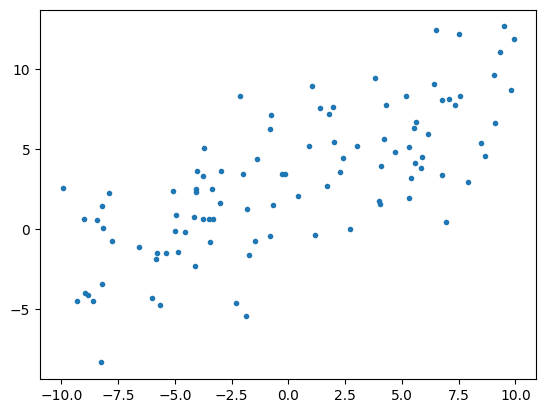

In [ ]:
# Simulate

w1 = 0.5
w0 = 3
sigma2 = 3
N = 100
err = np.random.normal(0,sigma2,N)
X = np.array(sorted(np.random.uniform(-10,10,N)))
T = w0 + X*w1 + err

plt.plot(X,T,".")
plt.show()

Assuming uniform prior for $w_0$, $w_1$ from -10 to 10
* __Posterior:__
    \begin{aligned}
    P(w_0,w_1|D)
    &\propto P(D|w_0,w_1)P(w_0,w_1)\\
    P(H_{linear}|D) &\propto \int_{-10}^{+10} \int_{-10}^{10} \prod_i \sqrt{\frac 1 {2 \pi \sigma^2}}e^{\frac {-(t_i-w_0-w_1 x_i)^2} {2 \sigma^2}} \, dw_0 dw_1\\
    P(H_{linear}|D)  &\propto  \int_{-10}^{10}\int_{-10}^{10}  e^ {\sum_i -0.5\ln 2\pi \sigma^2 {+\frac {-(t_i-w_0-w_1 x_i)^2} {2\sigma^2}} }\, dw_0 dw_1\\
    Log(P(H_{linear}|D))  &\propto  Log(\int_{-10}^{10}\int_{-10}^{10}  e^ {\sum_i -0.5\ln 2\pi \sigma^2 {+\frac {-(t_i-w_0-w_1 x_i)^2} {2\sigma^2}} }\, dw_0 dw_1)\\
    \end{aligned}

In [ ]:
def posterior(x, t, w0, w1,sigma2):

    logconst = -0.5*np.log(2*np.pi)*sigma2
    logprob = 0        # flat prior
    logprob = (-(t - w0 - w1*x)*(t - w0 - w1*x)/2/sigma2 + logconst).sum()

    return np.exp(logprob)



nbin   = 500
w0_min = -2
w0_max = +5
w1_min = -2
w1_max = +5

x0 = np.linspace(w0_min, w0_max, nbin)
x1 = np.linspace(w1_min, w1_max, nbin)

def posterior_pdf(X,T):
    h2 = []
    bsize_w0 = (w0_max - w0_min)/nbin #x0[1]-x0[0]
    bsize_w1 = (w1_max - w1_min)/nbin
    for b0 in range(nbin):
        w0 = w0_min + b0*bsize_w0
        row = []
        for b1 in range(nbin):
            w1 = w1_min + b1*bsize_w1
            ev = posterior(X, T, w0, w1,sigma2) * bsize_w0 * bsize_w1
            row.append(ev)
        h2.append(row)

    # normalization
    h2  = np.array(h2)/np.sum(np.array(h2))

    return h2


pdf= posterior_pdf(X,T)

In [ ]:
pdf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
w0 ,w1 = np.unravel_index(pdf.argmax(), pdf.shape)
w0,w1

(355, 184)

In [ ]:
x0[346], x1[179]

(2.8537074148296595, 0.5110220440881763)

Text(0.5, 1.0, 'posterior matrix matrix  zoomed')

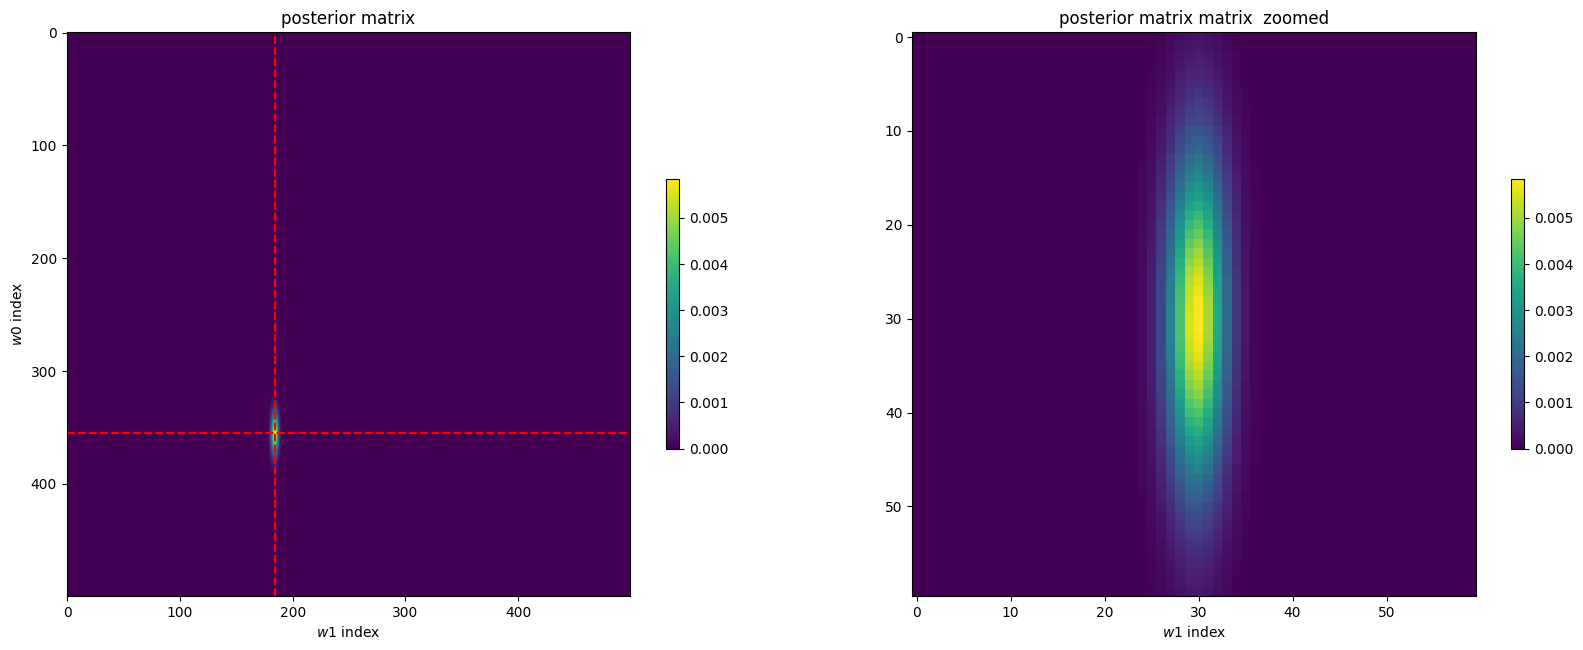

In [ ]:
fig,axs = subplots(ncols= 2,nrows =1)
fig.set_figwidth(20)
fig.set_figheight(10)
axs[0].imshow(pdf)

pcm = axs[1].imshow(pdf[int(w0-30):int(w0+30),int(w1-30):int(w1+30)])

axs[0].axvline(w1, c = 'r', ls ='--')
axs[0].axhline(w0, c = 'r', ls ='--')

fig.colorbar(pcm,ax=axs[0], shrink =0.35)
fig.colorbar(pcm,ax=axs[1], shrink =0.35)

axs[0].set_title('posterior matrix')
axs[0].set_ylabel(r'$w0$ index')
axs[0].set_xlabel(r'$w1$ index')
axs[1].set_xlabel(r'$w1$ index')
axs[1].set_title('posterior matrix matrix  zoomed')


Let's marginalize posterior distributions for each parameter.

In [ ]:
# from scipy.stats.contingency import margins
def marginalization(pdf):

    pdf_w0,pdf_w1 = pdf.sum(axis=1),pdf.sum(axis=0) #margins(pdf) # ~
    pdf_w0 = pdf_w0.T
    cdf_w0 = np.cumsum(pdf_w0)
    cdf_w1 = np.cumsum(pdf_w1)
    return cdf_w0,cdf_w1, pdf_w0,pdf_w1


cdf_w0,cdf_w1, pdf_w0,pdf_w1 = marginalization(pdf)

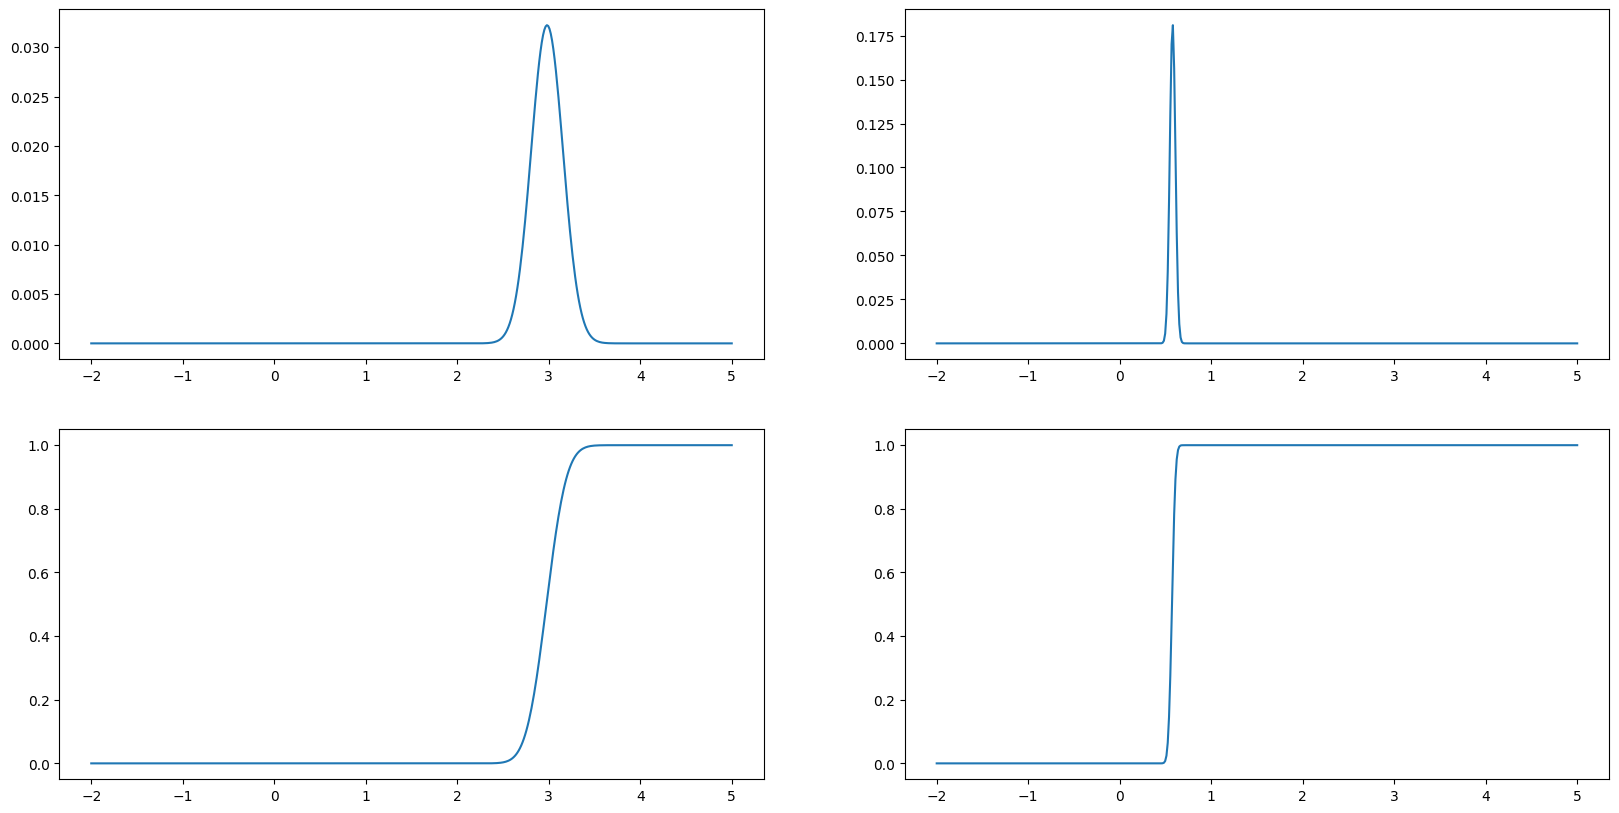

In [ ]:
fig,axs = subplots(ncols= 2,nrows =2)
fig.set_figwidth(20)
fig.set_figheight(10)
axs[0][0].plot(x0,pdf_w0)
axs[0][1].plot(x1,pdf_w1)
axs[1][0].plot(x0,cdf_w0)
axs[1][1].plot(x1,cdf_w1)

In [ ]:
def parameters_sample(cdf_w0,cdf_w1):
    r = np.random.uniform(low=0.0, high=1.0, size=2)
    i = int(np.argwhere(cdf_w0>r[0])[0] -1)
    i = max(i,0)
    w0_sampled = x0[i]
    i = int(np.argwhere(cdf_w1>r[1])[0] -1)
    i = max(i,0)

    w1_sampled = x0[i]

    return w0_sampled,w1_sampled

w0:  3.2324649298597192  w1:  0.49699398797595196
w0:  2.965931863727455  w1:  0.5250501002004007
w0:  2.8677354709418834  w1:  0.5250501002004007
w0:  2.9378757515030056  w1:  0.4689378757515028
w0:  3.2745490981963927  w1:  0.45490981963927846


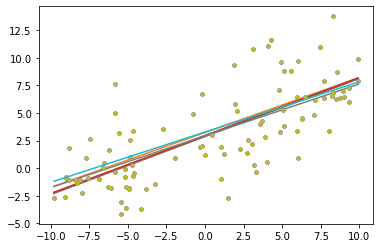

In [ ]:
def plot_sample(X,T,cdf_w0,cdf_w1):
    for i in range(5):
        w0_sampled,w1_sampled = parameters_sample(cdf_w0,cdf_w1)
        print("w0: ", w0_sampled," w1: ",w1_sampled)
        Y = []
        for i in range(len(X)):
            Y.append(w0_sampled + w1_sampled * X[i])

        plt.plot(X,T,".")
        plt.plot(X,Y)
    plt.show()

plot_sample(X,T,cdf_w0,cdf_w1)

In [ ]:
def sub_sampling(sub_idx):
    X1 = X[sub_idx]
    T1 = T[sub_idx]

    pdf1=posterior_pdf(X1,T1)
    cdf_w0_1,cdf_w1_1,_,_ = marginalization(pdf1)

    plot_sample(X1,T1,cdf_w0_1,cdf_w1_1)

w0:  2.6993987975951903  w1:  0.7074148296593186
w0:  2.993987975951904  w1:  0.6372745490981964
w0:  4.018036072144288  w1:  0.5671342685370742
w0:  2.993987975951904  w1:  0.7354709418837677
w0:  3.7935871743486977  w1:  0.49699398797595196


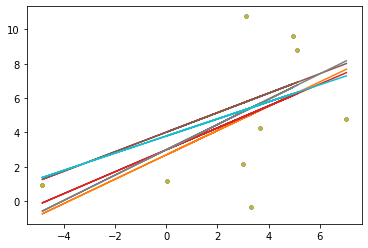

In [ ]:
sub_idx = np.random.choice(N, 10)
sub_sampling(sub_idx)

w0:  -0.9759519038076152  w1:  0.7915831663326656
w0:  -0.30260521042084165  w1:  0.006012024048096087
w0:  -1.8597194388777556  w1:  -0.34468937875751493
w0:  -1.9438877755511021  w1:  -0.3587174348697395
w0:  -2.0  w1:  -0.008016032064128265


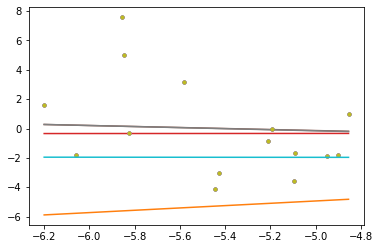

In [ ]:
sub_idx = range(17,32)
sub_sampling(sub_idx)

w0:  1.591182364729459  w1:  0.3006012024048097
w0:  -0.751503006012024  w1:  0.4128256513026054
w0:  3.5410821643286576  w1:  0.4408817635270541
w0:  -0.3306613226452906  w1:  0.5811623246492985
w0:  3.3026052104208414  w1:  0.35671342685370755


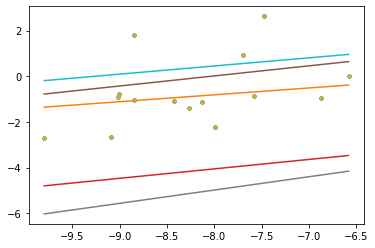

In [ ]:
sub_idx = range(15)
sub_sampling(sub_idx)

w0:  3.3867735470941884  w1:  0.6372745490981964
w0:  1.8717434869739478  w1:  0.42685370741482975
w0:  2.0400801603206418  w1:  0.7494989979959921
w0:  3.2745490981963927  w1:  0.9599198396793587
w0:  1.6893787575150303  w1:  0.6372745490981964


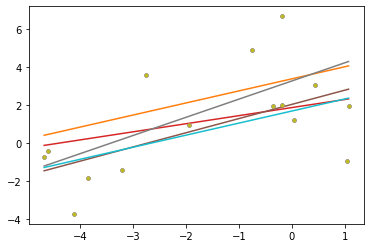

In [ ]:
sub_idx = range(35,50)
sub_sampling(sub_idx)

w0:  1.6192384769539077  w1:  0.21643286573146314
w0:  1.7595190380761525  w1:  0.5390781563126255
w0:  1.6613226452905812  w1:  0.42685370741482975
w0:  2.657314629258517  w1:  0.27254509018036055
w0:  2.3206412825651306  w1:  0.21643286573146314


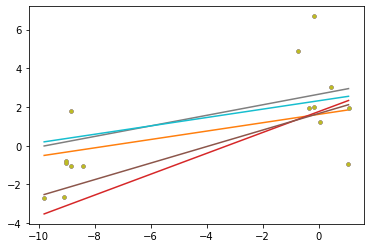

In [ ]:
sub_idx = list(range(7))+list(range(42,50))
sub_sampling(sub_idx)

From Wikipedia: "the Metropolis–Hastings algorithm is a Markov chain Monte Carlo (MCMC) method for obtaining a sequence of random samples from a probability distribution from which direct sampling is difficult"
https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm

Here in our case, the full posterior distribution is a 2D pdf, which is hard to sample directly.
The algorithm goes as follows:

* we start with some initial parameters $\Theta$ and calculating the probability with $\Theta$
* In each iterations:
    * modify the previous parameters by a small value
    * calculate the new probability with the new parameters
    * calculate the ratio $\alpha = \frac {P_{new}} {P_{prev}}$

    
* Take the mean values of the parameters after convergence  

Populating the interactive namespace from numpy and matplotlib


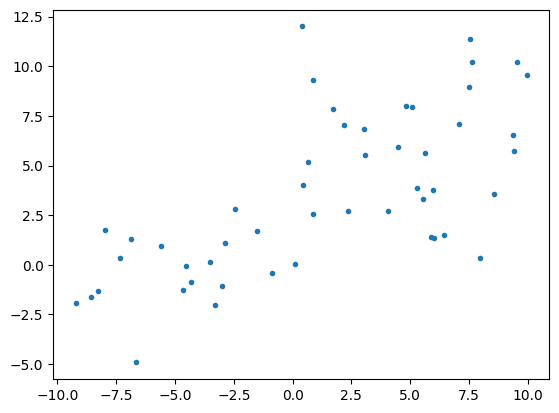

In [ ]:
%pylab inline
# Simulate points
w1 = 0.5
w0 = 3
sigma2 = 3
N = 50
err = np.random.normal(0,sigma2,N)
X = np.array(sorted(np.random.uniform(-10,10,N)))
T = w0 + X*w1 + err



plt.plot(X,T,".")
plt.show()


In [ ]:
from scipy.special import logsumexp
def log_posterior(x, t, w0, w1,sigma2):
    logconst = -0.5*np.log(2*np.pi)*sigma2
    logP = 0        # flat prior
    logP = sum(-(t - w0 - w1*x)*(t - w0 - w1*x)/2/sigma2 + logconst)
    return logP



w0_prev = 0
w1_prev = 0

posterior_prev=  log_posterior(X, T, w0_prev, w1_prev,sigma2)


iterations = 100000

w0_sampled = np.empty(iterations)
w1_sampled = np.empty(iterations)
for i in range(iterations):
    # draw a new set of parameters using previous value
    w0_cur = w0_prev+np.random.normal(0, 0.1)
    w1_cur = w1_prev+np.random.normal(0, 0.1)

    # calculate the posterior with the new parameters
    posterior_cur =  log_posterior(X, T, w0_cur, w1_cur,sigma2)

    #calculate the ratio
    alpha = logsumexp(posterior_cur-posterior_prev)
    if alpha >0:
        u = np.random.uniform()
        if u>=alpha: # reject the current
            w0_prev = w0_prev
            w1_prev = w1_prev
            posterior_prev = posterior_prev

        elif u<alpha: # accept with probability alpha
            w0_prev = w0_cur
            w1_prev = w1_cur
            posterior_prev = posterior_cur

    # Update the result arrays
    w0_sampled[i] = w0_prev
    w1_sampled[i] = w1_prev



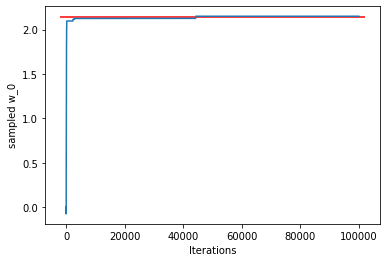

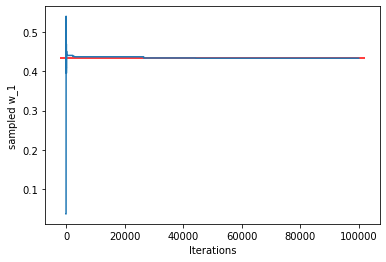

In [ ]:
plt.plot(list(range(iterations)), w0_sampled)
plt.hlines(np.mean(w0_sampled[1000:]), -2000, iterations+2000, 'r')
plt.xlabel("Iterations")
plt.ylabel("sampled w_0")
plt.show()

plt.plot(list(range(iterations)), w1_sampled)
plt.hlines(np.mean(w1_sampled[1000:]), -2000, iterations+2000,'r')
plt.xlabel("Iterations")
plt.ylabel("sampled w_1")
plt.show()

In [ ]:
from scipy.special import logsumexp
def log_posterior(x, t, w0, w1,sigma2):
    logconst = -0.5*np.log(2*np.pi)*sigma2
    logP = 0        # flat prior
    logP = sum(-(t - w0 - w1*x)*(t - w0 - w1*x)/2/sigma2 + logconst)
    return logP



w0_prev = 0
w1_prev = 0

posterior_prev=  log_posterior(X, T, w0_prev, w1_prev,sigma2)


iterations = 100000

w0_sampled = []
w1_sampled = []
i = 0
stop=1
while stop == 1:

    # draw a new set of parameters using previous value
    w0_cur = w0_prev+np.random.normal(0, 0.1)
    w1_cur = w1_prev+np.random.normal(0, 0.1)

    # calculate the posterior with the new parameters
    posterior_cur =  log_posterior(X, T, w0_cur, w1_cur,sigma2)

    #calculate the ratio
    alpha = logsumexp(posterior_cur-posterior_prev)
    if alpha >0:
        u = np.random.uniform()
        if u>=alpha: # reject the current
            w0_prev = w0_prev
            w1_prev = w1_prev
            posterior_prev = posterior_prev

        elif u<alpha: # accept with probability alpha
            w0_prev = w0_cur
            w1_prev = w1_cur
            posterior_prev = posterior_cur

    # Update the result arrays
    w0_sampled.append(w0_prev)
    w1_sampled.append(w1_prev)

    i += 1

    if i >1000:
        if (w0_sampled[-1] - w0_sampled[-2] == 0) and (w1_sampled[-1] - w1_sampled[-2] == 0):
            stop = 0




In [ ]:
len(w0_sampled)

1001

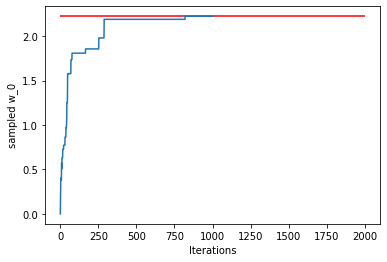

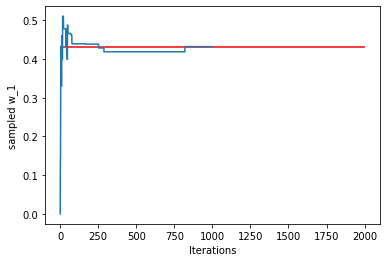

In [ ]:
plt.plot(list(range(len(w0_sampled))), w0_sampled)
plt.hlines(np.mean(w0_sampled[1000:]), 0, 2000, 'r')
plt.xlabel("Iterations")
plt.ylabel("sampled w_0")
plt.show()

plt.plot(list(range(len(w1_sampled))), w1_sampled)
plt.hlines(np.mean(w1_sampled[1000:]), 0, 2000,'r')
plt.xlabel("Iterations")
plt.ylabel("sampled w_1")
plt.show()